## Imports libraries

In [1]:
import pandas as pd
import numpy as np
import glob
import string
import pickle 
import warnings
warnings.filterwarnings('ignore')

import re
import nltk
import torch
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import OrderedDict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier, plot_importance
from wordcloud import WordCloud, STOPWORDS
from bs4 import BeautifulSoup
from scipy.sparse import hstack
from scipy import sparse
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

## Read Datasets

In [2]:
#load data
train_df=pd.read_csv('bt5153-applied-machine-learning-2022/train.csv')
test_df=pd.read_csv('bt5153-applied-machine-learning-2022/test.csv').fillna(' ')
display(
    train_df.head(), 
    train_df.info(),
    test_df.head(),
    test_df.info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48162 entries, 0 to 48161
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  48162 non-null  object
 1   Outcome  48162 non-null  int64 
 2   Id       48162 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28863 entries, 0 to 28862
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  28863 non-null  object
 1   Id       28863 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 451.1+ KB


,Comment,Outcome,Id
0,use variables in the outer function instead of...,1,17489
1,if you're looking for something as nice as pyt...,1,37982
2,"i use the tail() function: tail(vector, n=1) t...",1,29641
3,combining lindelof's and gregg lind's ideas: l...,1,39557
4,you can drop any row containing a missing usin...,1,14288


None

,Comment,Id
0,clearly i should have worked on this for anoth...,57525
1,in most cases r is an interpreted language tha...,62692
2,most of the algorithms for eigen value computa...,54789
3,if you're willing to entertain an alternate pl...,61455
4,try littler. littler provides hash-bang (i.e. ...,78000


None

## Exploratory Data Analysis

1    28851
0    19311
Name: Outcome, dtype: int64

<AxesSubplot:ylabel='Outcome'>

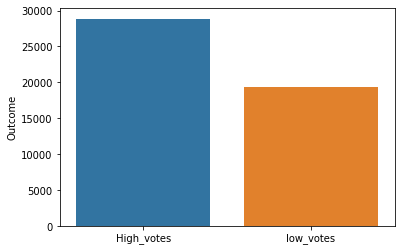

In [3]:
display(
    train_df['Outcome'].value_counts(),
    sns.barplot(x=['High_votes', 'low_votes'], y=train_df.Outcome.value_counts())
)

In [4]:
train_df['Outcome'].value_counts()/len(train_df)

1    0.599041
0    0.400959
Name: Outcome, dtype: float64

### Word Cloud for Each Class

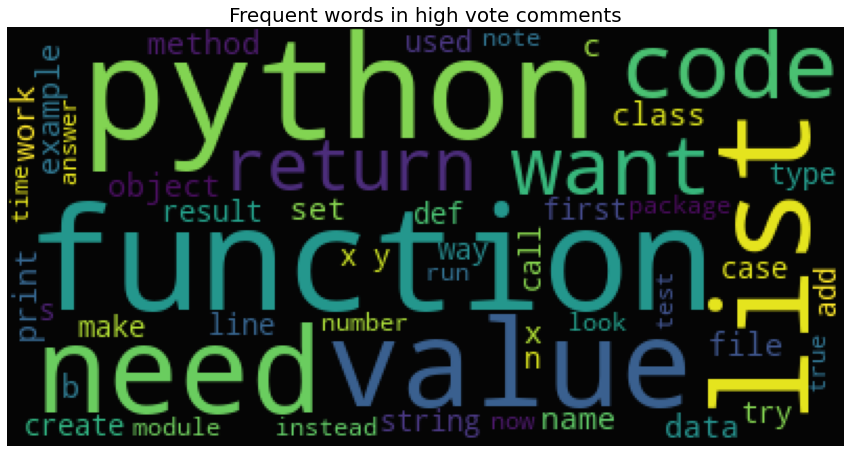

In [5]:
updated_STOPWORDS = ['below','will','use','using', 'one', 'see']
High_votes = train_df[train_df.Outcome == 1]['Comment'].values
wc = WordCloud(background_color="black", max_words=50, stopwords=STOPWORDS.update(updated_STOPWORDS))
wc.generate(" ".join(High_votes))

plt.figure(figsize=(15,12))
plt.axis("off")
plt.title("Frequent words in high vote comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

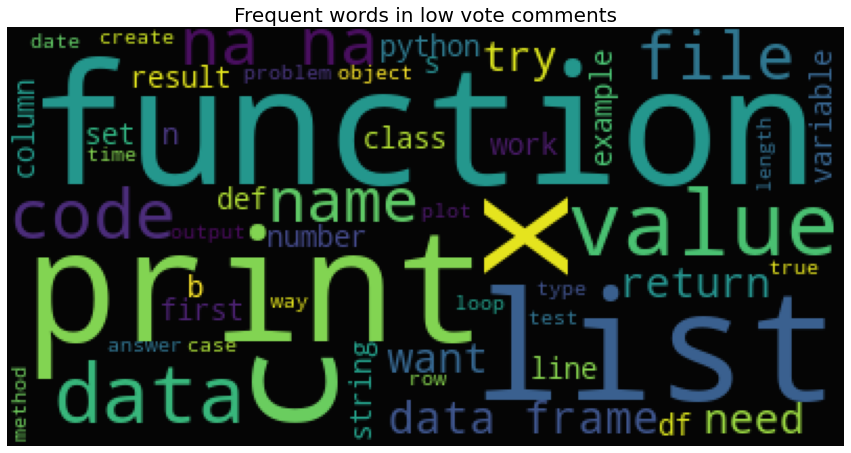

In [6]:
low_votes = train_df[train_df.Outcome == 0]['Comment'].values
wc = WordCloud(background_color="black", max_words=50, stopwords=STOPWORDS.update(updated_STOPWORDS))
wc.generate(" ".join(low_votes))

plt.figure(figsize=(15,12))
plt.axis("off")
plt.title("Frequent words in low vote comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

## Text Preprocessing

#### Lowercase, Fillna and Remove extra white spaces

In [7]:
import texthero as hero

In [8]:
clean_pipeline_1 = [hero.preprocessing.lowercase,
                    hero.preprocessing.remove_diacritics,
                    hero.preprocessing.fillna,
                    hero.preprocessing.remove_whitespace,
                   ]

train_df['clean1'] = train_df['Comment'].pipe(hero.clean, clean_pipeline_1)
test_df['clean1'] = test_df['Comment'].pipe(hero.clean, clean_pipeline_1)
# train_df[['clean','Comment']].head(15).values

## Feature Extraction

#### Number of characters

<AxesSubplot:>

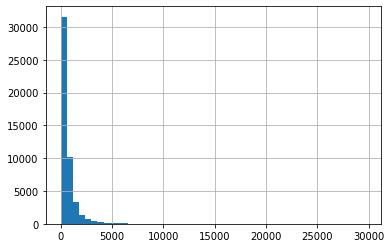

In [9]:
train_df['num_chars'] = [len(i) for i in train_df['clean1']]
test_df['num_chars'] = [len(i) for i in test_df['clean1']]
pd.Series(train_df['num_chars']).hist(bins = 50)

#### Number of sequences

<AxesSubplot:>

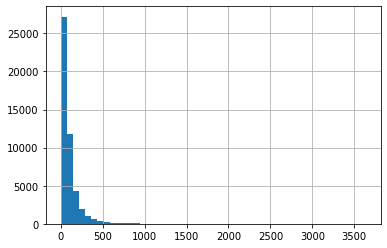

In [10]:
train_df['num_words'] = [len(i.split()) for i in train_df['clean1']]
test_df['num_words'] = [len(i.split()) for i in test_df['clean1']]
pd.Series(train_df['num_words']).hist(bins = 50)

#### Number of URLS

In [11]:
%%time
def find_urls(text):
    urls = re.findall('(https?:\/\/(?:www\.|(?!www\.))|www\.)',text)
    return urls

train_df['urls'] = train_df['clean1'].apply(find_urls)
test_df['urls'] = test_df['clean1'].apply(find_urls)

train_df['num_urls'] = train_df['urls'].apply(len)
test_df['num_urls'] = test_df['urls'].apply(len)

train_df.loc[train_df['num_urls']>5, 'num_urls'] = 5
test_df.loc[test_df['num_urls']>5, 'num_urls'] = 5

# save for further use
train_df.to_csv("Train_numurls_len_regex_2503.csv", index=False)
test_df.to_csv("Test_numurls_len_regex_2503.csv", index=False)

train_df['num_urls'].value_counts(), test_df['num_urls'].value_counts()

CPU times: user 1.78 s, sys: 53 ms, total: 1.83 s
Wall time: 1.4 s


(0    43441
 1     3513
 2      745
 3      235
 5      138
 4       90
 Name: num_urls, dtype: int64,
 0    26401
 1     1818
 2      424
 3      121
 5       56
 4       43
 Name: num_urls, dtype: int64)

#### Remove HTML, Remove URLS

In [12]:
clean_pipeline_2 = [hero.preprocessing.remove_urls,
                    hero.preprocessing.remove_html_tags,
                    hero.preprocessing.fillna,
                    hero.preprocessing.remove_whitespace,
                   ]

train_df['clean2'] = train_df['clean1'].pipe(hero.clean, clean_pipeline_2)
test_df['clean2'] = test_df['clean1'].pipe(hero.clean, clean_pipeline_2)

#### Number of Codeblocks

In [13]:
def find_code(text):
    for i in text.split():
        if len(i) > 25:
            return 1
    return 0

train_df['code'] = train_df['clean2'].apply(find_code)
test_df['code'] = test_df['clean2'].apply(find_code)
# train_df[['clean','code']][:15].values

In [14]:
train_df['code'].value_counts()

0    29473
1    18689
Name: code, dtype: int64

## Text Cleaning 

#### Remove Stopwords - Along with customized stopwords list, Remove Punctutions

In [15]:
clean_pipeline_3 = [hero.preprocessing.remove_punctuation,
                    hero.preprocessing.remove_stopwords,
                    hero.preprocessing.remove_digits,
                    hero.preprocessing.fillna,
                    hero.preprocessing.remove_whitespace
                   ]

train_df['clean3'] = train_df['clean2'].pipe(hero.clean, clean_pipeline_3)
test_df['clean3'] = test_df['clean2'].pipe(hero.clean, clean_pipeline_3)
# train_df[['clean','Comment']].head(15).values

#### Remove words with characters <=3

In [16]:
train_df['clean3'] = hero.preprocessing.remove_whitespace(train_df['clean3'].apply(
    lambda sentence: ' '.join(
        [word if len(word)>=3 else '' for word in sentence.split()])))

#### Miscellaneous Cleaning if any

#### Save preprocessed text file

In [17]:
# save for further use
train_df.to_csv("Train_feature_engineering_2503.csv", index=False)
test_df.to_csv("Test_feature_engineering_2503.csv", index=False)

## Analysing newly created features

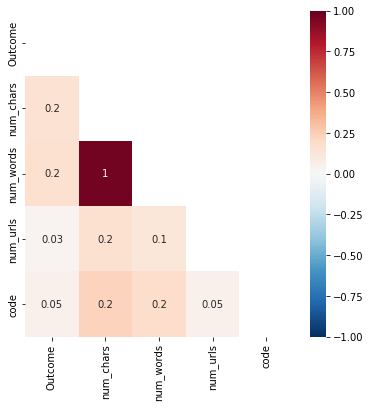

In [19]:
correlated = np.triu(train_df.drop('Id', axis=1).corr())
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(train_df.drop('Id', axis=1).corr(), annot=True, ax=ax, fmt='.1g', vmin=-1, vmax=1, center= 0, mask=correlated, cmap='RdBu_r')
plt.show()

#### Dropping num_chars since both num_chars and num_words are highly correlated with representation of same inference. URLs are not required anymore, only keeping the num_urls feature

In [20]:
train_df = train_df.drop(['num_chars','urls'], axis=1)
test_df = test_df.drop(['num_chars','urls'], axis=1)

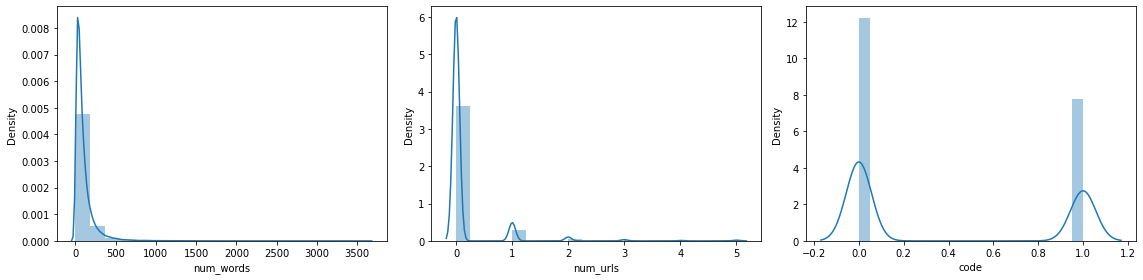

In [21]:
fig = plt.figure(figsize=(16, 4))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

sns.distplot(train_df['num_words'], bins=20, ax=ax1)
sns.distplot(train_df['num_urls'], bins=20, ax=ax2)
sns.distplot(train_df['code'], bins=20, ax=ax3)

plt.tight_layout()
plt.show()

**Skewness Analytics Inferences:**

- num_words and num_urls do not follow a normal distribution.The distributions for these 2 features are skewed right.
- There are a lot of outliers in terms of these two features. 
- Most of the data points have less than 500 seuence length and less than 3 urls

## Feature Transform Numerical/Categorical Engineered Features

#### Scaler transform numerical features num_words, No Categorical features - no encoding required

In [22]:
scale = ['num_words', 'num_urls']
scaler=StandardScaler()
scaler.fit(train_df[scale])
train_df[scale]=pd.DataFrame(scaler.transform(train_df[scale]),columns=scale)
train_df.shape

(48162, 9)

## TfidfVectorizer with Word and Character n-grams

In [23]:
%%time
# train_text = train_df['Comment']
# test_text = test_df['Comment']
train_text = train_df['clean1']
test_text = test_df['clean1']
# train_text = train_df['clean2']
# test_text = test_df['clean2']
# train_text = train_df['clean3']
# test_text = test_df['clean3']
all_text = pd.concat([train_text, test_text])

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=100000)
word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 7),
    max_features=500000)
char_vectorizer.fit(all_text)
train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])
sparse.save_npz('train_features_engineered.npz', train_features, compressed=True)
sparse.save_npz('test_features_engineered.npz', test_features, compressed=True)

display(
    train_features.shape,
    test_features.shape
)

(48162, 600000)

(28863, 600000)

CPU times: user 5min 46s, sys: 12.1 s, total: 5min 58s
Wall time: 6min 2s


#### Loading Sparse features matrices

In [24]:
train_features = sparse.load_npz('train_features_engineered.npz')
test_features = sparse.load_npz('test_features_engineered.npz')
train_features.shape, test_features.shape

((48162, 600000), (28863, 600000))

## Combine Vectorized Features and Transformed Numerical features

In [25]:
train_features = hstack((train_features, hstack(train_df['code'], dtype='float').T.tocsr()))
train_features = hstack((train_features, hstack(train_df['num_urls'], dtype='float').T.tocsr()))
train_features = hstack((train_features, hstack(train_df['num_words'], dtype='float').T.tocsr()))
train_features.shape

(48162, 600003)

In [26]:
test_features = hstack((test_features, hstack(test_df['code'], dtype='float').T.tocsr()))
test_features = hstack((test_features, hstack(test_df['num_urls'], dtype='float').T.tocsr()))
test_features = hstack((test_features, hstack(test_df['num_words'], dtype='float').T.tocsr()))
test_features.shape

(28863, 600003)

### 3.2 Build Logistic Regression

In [27]:
#get labels
labels = train_df.Outcome.tolist()

#compute the class weights
class_wts = compute_class_weight(class_weight = 'balanced', classes = np.unique(labels), y = labels)
class_wts = {0:class_wts[0], 1:class_wts[1]}
class_wts

{0: 1.2470094764641915, 1: 0.8346677758136634}

In [28]:
%time
X_train, X_test, y_train, y_test = train_test_split(train_features, labels, test_size=0.30, stratify=labels, random_state=123)
lr_clf = LogisticRegression(C=1, class_weight=class_wts, max_iter=50000)
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)

#validate the model
lr_accuracy = lr_clf.score(X_test, y_test)
print(lr_clf.score(X_test, y_test))
print(classification_report(y_test, lr_preds))
print(pd.crosstab(y_test, lr_preds))

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 3.81 µs
0.7506401827116064
              precision    recall  f1-score   support

           0       0.68      0.72      0.70      5793
           1       0.81      0.77      0.79      8656

    accuracy                           0.75     14449
   macro avg       0.74      0.75      0.74     14449
weighted avg       0.75      0.75      0.75     14449

col_0     0     1
row_0            
0      4197  1596
1      2007  6649


In [29]:
lr_clf.get_params()

{'C': 1,
 'class_weight': {0: 1.2470094764641915, 1: 0.8346677758136634},
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 50000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [30]:
# cross validate logistic regression
%time
from sklearn.model_selection import RepeatedStratifiedKFold
lr_clf_cv = LogisticRegression(C=1, class_weight=class_wts, max_iter=50000)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
cv_accuracy = np.mean(cross_val_score(lr_clf_cv, train_features, labels, cv=cv, scoring='accuracy'))
print('CV score for class is {}'.format(cv_accuracy))

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 6.2 µs
CV score for class is 0.7519206591486746


#### Fine-Tune Logistic Regression Threshold


~~~~~~~~~~~~~ For i = 0.2 ~~~~~~~~~~~
Validation accuracy is 0.6864834936673818
[[1507 4286]
 [ 244 8412]]

~~~~~~~~~~~~~ For i = 0.3 ~~~~~~~~~~~
Validation accuracy is 0.7329226936120147
[[2581 3212]
 [ 647 8009]]

~~~~~~~~~~~~~ For i = 0.4 ~~~~~~~~~~~
Validation accuracy is 0.7533393314416222
[[3479 2314]
 [1250 7406]]

~~~~~~~~~~~~~ For i = 0.45 ~~~~~~~~~~~
Validation accuracy is 0.7551387639282995
[[3838 1955]
 [1583 7073]]

~~~~~~~~~~~~~ For i = 0.5 ~~~~~~~~~~~
Validation accuracy is 0.7506401827116064
[[4197 1596]
 [2007 6649]]

~~~~~~~~~~~~~ For i = 0.55 ~~~~~~~~~~~
Validation accuracy is 0.7377673195376843
[[4507 1286]
 [2503 6153]]

~~~~~~~~~~~~~ For i = 0.57 ~~~~~~~~~~~
Validation accuracy is 0.7312616790089279
[[4621 1172]
 [2711 5945]]

~~~~~~~~~~~~~ For i = 0.58 ~~~~~~~~~~~
Validation accuracy is 0.7275243961519828
[[4680 1113]
 [2824 5832]]

~~~~~~~~~~~~~ For i = 0.6 ~~~~~~~~~~~
Validation accuracy is 0.720880337739636
[[4824  969]
 [3064 5592]]

~~~~~~~~~~~~~ For i = 0.

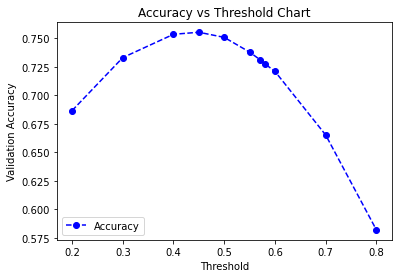

In [31]:
pred_proba_df = pd.DataFrame(lr_clf.predict_proba(X_test))
thresholds = [0.2,0.3,0.4,0.45,0.5,0.55,0.57,0.58,0.6,0.7,0.8]
validation_accuracy = []

for i in thresholds:
    print ('\n~~~~~~~~~~~~~ For i = {} ~~~~~~~~~~~'.format(i))
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)[1]
    val_accuracy = accuracy_score(y_test,y_test_pred) 
    validation_accuracy.append(val_accuracy)
    print('Validation accuracy is {}'.format(val_accuracy))
    print(confusion_matrix(y_test,y_test_pred))

plt.title("Accuracy vs Threshold Chart")
plt.plot(thresholds, validation_accuracy, "b--", marker='o', label="Accuracy")
plt.ylabel("Validation Accuracy")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
# plt.ylim([0,1])

#### Prepare submission from LR

In [32]:
threshold = 0.55
lr_clf = LogisticRegression(C=1, class_weight=class_wts, max_iter=50000)
lr_clf.fit(train_features, labels)
pred_proba_df = pd.DataFrame(lr_clf.predict_proba(test_features))
submission = pd.DataFrame.from_dict({'Id': test_df['Id']})
submission['Outcome'] = pred_proba_df.applymap(lambda x: 1 if x>=threshold else 0)[1]
submission.to_csv(f'submission_feature_engineered_lr_tuned_{cv_accuracy}.csv', index=False)

In [33]:
submission.head()

,Id,Outcome
0,57525,1
1,62692,1
2,54789,1
3,61455,1
4,78000,1


### 3.2 Build XGBoost Classifier

In [34]:
labels = train_df.Outcome.tolist()
#compute the class weights
class_wts = compute_class_weight(class_weight = 'balanced', classes = np.unique(labels), y = labels)
class_wts = {0:class_wts[0],
            1:class_wts[1]}
class_wts

{0: 1.2470094764641915, 1: 0.8346677758136634}

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train_features, labels, test_size=0.30, stratify=labels, random_state=123)
xgb_clf = XGBClassifier(n_estimators=600, sample_weight=class_wts)
xgb_clf.fit(X_train, y_train)
xgb_preds = xgb_clf.predict(X_test)

#validate the model
xgb_accuracy=xgb_clf.score(X_test, y_test)
print(xgb_accuracy)
print(classification_report(y_test, xgb_preds))
print(pd.crosstab(y_test, xgb_preds))xgb_clf.get_params

0.7388746626064088
              precision    recall  f1-score   support

           0       0.70      0.61      0.65      5736
           1       0.76      0.83      0.79      8713

    accuracy                           0.74     14449
   macro avg       0.73      0.72      0.72     14449
weighted avg       0.74      0.74      0.74     14449

col_0     0     1
row_0            
0      3484  2252
1      1521  7192


In [16]:
xgb_clf.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=700, n_jobs=1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)>

### Evaluate Classification model using Repeated cross validation

In [ ]:

%time
from sklearn.model_selection import RepeatedStratifiedKFold
xgb_clf_cv = XGBClassifier(n_estimators=600, learning_rate=0.1)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
cv_accuracy = np.mean(cross_val_score(xgb_clf_cv, train_features, labels, cv=cv, scoring='accuracy'))
print('CV score for class is {}'.format(cv_accuracy))

#### Hyper parameter tuning of XGB model

In [45]:
xgb_C = XGBClassifier()
eval_set = [(X_train, y_train), (X_test, y_test)]
%time xgb_C.fit(X_train, y_train, eval_metric='logloss', eval_set=eval_set,verbose=True)

[0]	validation_0-logloss:0.64609	validation_1-logloss:0.65093
[1]	validation_0-logloss:0.61679	validation_1-logloss:0.62723
[2]	validation_0-logloss:0.59426	validation_1-logloss:0.61095
[3]	validation_0-logloss:0.57728	validation_1-logloss:0.59921
[4]	validation_0-logloss:0.56429	validation_1-logloss:0.59198
[5]	validation_0-logloss:0.55276	validation_1-logloss:0.58561
[6]	validation_0-logloss:0.54234	validation_1-logloss:0.58050
[7]	validation_0-logloss:0.53378	validation_1-logloss:0.57627
[8]	validation_0-logloss:0.52704	validation_1-logloss:0.57219
[9]	validation_0-logloss:0.51910	validation_1-logloss:0.56876
[10]	validation_0-logloss:0.51134	validation_1-logloss:0.56563
[11]	validation_0-logloss:0.50540	validation_1-logloss:0.56326
[12]	validation_0-logloss:0.49764	validation_1-logloss:0.56098
[13]	validation_0-logloss:0.49348	validation_1-logloss:0.55945
[14]	validation_0-logloss:0.48919	validation_1-logloss:0.55834
[15]	validation_0-logloss:0.48353	validation_1-logloss:0.55623
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [47]:
# evaluate performance
y_preds = xgb_C.predict(X_test)
score = accuracy_score(y_test, y_preds)
print('Accuracy: %.3f' % score)
# retrieve performance metrics
results = xgb_C.evals_result()

Accuracy: 0.735


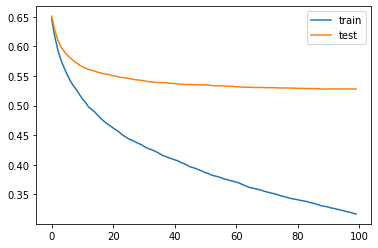

In [48]:
from matplotlib import pyplot
# plot learning curves
pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

[0]	validation_0-logloss:0.64609	validation_1-logloss:0.65093
[1]	validation_0-logloss:0.61679	validation_1-logloss:0.62723
[2]	validation_0-logloss:0.59426	validation_1-logloss:0.61095
[3]	validation_0-logloss:0.57728	validation_1-logloss:0.59921
[4]	validation_0-logloss:0.56429	validation_1-logloss:0.59198
[5]	validation_0-logloss:0.55276	validation_1-logloss:0.58561
[6]	validation_0-logloss:0.54234	validation_1-logloss:0.58050
[7]	validation_0-logloss:0.53378	validation_1-logloss:0.57627
[8]	validation_0-logloss:0.52704	validation_1-logloss:0.57219
[9]	validation_0-logloss:0.51910	validation_1-logloss:0.56876
[10]	validation_0-logloss:0.51134	validation_1-logloss:0.56563
[11]	validation_0-logloss:0.50540	validation_1-logloss:0.56326
[12]	validation_0-logloss:0.49764	validation_1-logloss:0.56098
[13]	validation_0-logloss:0.49348	validation_1-logloss:0.55945
[14]	validation_0-logloss:0.48919	validation_1-logloss:0.55834
[15]	validation_0-logloss:0.48353	validation_1-logloss:0.55623
[1

[130]	validation_0-logloss:0.28817	validation_1-logloss:0.52898
[131]	validation_0-logloss:0.28745	validation_1-logloss:0.52890
[132]	validation_0-logloss:0.28669	validation_1-logloss:0.52882
[133]	validation_0-logloss:0.28596	validation_1-logloss:0.52879
[134]	validation_0-logloss:0.28447	validation_1-logloss:0.52892
[135]	validation_0-logloss:0.28379	validation_1-logloss:0.52891
[136]	validation_0-logloss:0.28272	validation_1-logloss:0.52892
[137]	validation_0-logloss:0.28217	validation_1-logloss:0.52894
[138]	validation_0-logloss:0.28146	validation_1-logloss:0.52871
[139]	validation_0-logloss:0.28073	validation_1-logloss:0.52850
[140]	validation_0-logloss:0.27959	validation_1-logloss:0.52835
[141]	validation_0-logloss:0.27889	validation_1-logloss:0.52821
[142]	validation_0-logloss:0.27826	validation_1-logloss:0.52814
[143]	validation_0-logloss:0.27735	validation_1-logloss:0.52797
[144]	validation_0-logloss:0.27647	validation_1-logloss:0.52827
[145]	validation_0-logloss:0.27577	valid

[259]	validation_0-logloss:0.19828	validation_1-logloss:0.52897
[260]	validation_0-logloss:0.19769	validation_1-logloss:0.52891
[261]	validation_0-logloss:0.19730	validation_1-logloss:0.52899
[262]	validation_0-logloss:0.19682	validation_1-logloss:0.52914
[263]	validation_0-logloss:0.19653	validation_1-logloss:0.52917
[264]	validation_0-logloss:0.19597	validation_1-logloss:0.52921
[265]	validation_0-logloss:0.19567	validation_1-logloss:0.52921
[266]	validation_0-logloss:0.19528	validation_1-logloss:0.52922
[267]	validation_0-logloss:0.19475	validation_1-logloss:0.52949
[268]	validation_0-logloss:0.19417	validation_1-logloss:0.52933
[269]	validation_0-logloss:0.19362	validation_1-logloss:0.52955
[270]	validation_0-logloss:0.19323	validation_1-logloss:0.52969
[271]	validation_0-logloss:0.19297	validation_1-logloss:0.52947
[272]	validation_0-logloss:0.19264	validation_1-logloss:0.52948
[273]	validation_0-logloss:0.19221	validation_1-logloss:0.52959
[274]	validation_0-logloss:0.19152	valid

[388]	validation_0-logloss:0.14555	validation_1-logloss:0.53586
[389]	validation_0-logloss:0.14498	validation_1-logloss:0.53584
[390]	validation_0-logloss:0.14467	validation_1-logloss:0.53585
[391]	validation_0-logloss:0.14436	validation_1-logloss:0.53580
[392]	validation_0-logloss:0.14413	validation_1-logloss:0.53585
[393]	validation_0-logloss:0.14391	validation_1-logloss:0.53587
[394]	validation_0-logloss:0.14336	validation_1-logloss:0.53624
[395]	validation_0-logloss:0.14282	validation_1-logloss:0.53639
[396]	validation_0-logloss:0.14253	validation_1-logloss:0.53633
[397]	validation_0-logloss:0.14222	validation_1-logloss:0.53638
[398]	validation_0-logloss:0.14183	validation_1-logloss:0.53646
[399]	validation_0-logloss:0.14158	validation_1-logloss:0.53650
[400]	validation_0-logloss:0.14135	validation_1-logloss:0.53641
[401]	validation_0-logloss:0.14115	validation_1-logloss:0.53634
[402]	validation_0-logloss:0.14093	validation_1-logloss:0.53620
[403]	validation_0-logloss:0.14069	valid

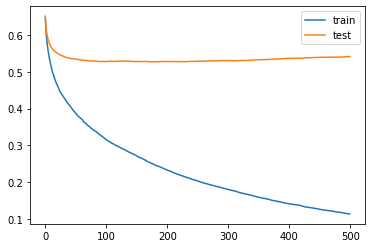

In [49]:
# define the model
model = XGBClassifier(n_estimators=500)
# define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_test,y_test)]
# fit the model
model.fit(X_train, y_train, eval_metric='logloss', eval_set=evalset)
# evaluate performance
yhat = model.predict(X_test)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)
# retrieve performance metrics
results = model.evals_result()
# plot learning curves
pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

**Fine tuned xgb model by increasing the n_estimators = 600
Tried fine tuning with eta (learning rate decresed to 0.05 but since the logloss was not decreasing after 300+ iterations as compared to increase in n_estimators from default to n_estimators=600**

#### Train on entire training dataset & Prepare submission.csv

In [57]:
%%time
xgb_clf_all = XGBClassifier(n_estimators=600)
xgb_clf_all.fit(train_features, labels)
submission = pd.DataFrame.from_dict({'Id': test['Id']})
submission['Outcome'] = xgb_clf_all.predict(test_features)
submission.to_csv('submission_xgb_all_tuned_600.csv', index=False)

[12:18:35] WARNING: /private/var/folders/_0/n4532gdd0lzfngk_qy30wzc00000gq/T/pip-install-d3gjks6n/xgboost_f9ce3749346347509b80299b8aa8cfd2/build/temp.macosx-12-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
